# Máster IA - Universidad de Valencia

## Trabajo: Deep Learning

##Título: Clasificación de acentos mediante RNN

### Alumno: Javier Cupeiro

#### Descripción:
Se ha buscado un dataset de voces en español con diferentes acentos, el objetivo es desarrollar varios modelos de RNN para compararlos y ver cual funciona mejor.

---
## Cargamos los datos

In [2]:
from google.colab import drive

# Datos de drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#basic_path = '/content/drive/MyDrive/audios_es/'
#path_datos = basic_path

basic_path = '/content/drive/MyDrive/Master_IA_UV/03 - Deep Learning 2/08 - Trabajo/'
path_datos = basic_path + 'dataset/cv-corpus-16.1-delta-2023-12-06/es/'

file_other = path_datos + 'other.tsv'
file_validated = path_datos + 'validated.tsv'
file_duration  = path_datos + 'clip_durations.tsv'

In [4]:
import pandas as pd

In [5]:
ds_other = pd.read_csv(file_other, header=0, sep='\t')
ds_other.shape

(11785, 11)

In [6]:
ds_validated = pd.read_csv(file_validated, header=0, sep='\t')
ds_validated.shape

(36, 11)

In [7]:
ds_duration = pd.read_csv(file_duration, header=0, sep='\t')
ds_duration.shape

(11823, 2)

## Exploración de los datos

In [8]:
ds_other.head(5)

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,ea34a71769790012dee861724c743833351c688e3466c3...,common_voice_es_38489062.mp3,Desde entonces se continúan organizando actos ...,0,0,NaN,NaN,"España: Sur peninsular (Andalucia, Extremadura...",NaN,es,NaN
1,ea34a71769790012dee861724c743833351c688e3466c3...,common_voice_es_38489063.mp3,Los representantes argumentaron que sería poco...,0,0,NaN,NaN,"España: Sur peninsular (Andalucia, Extremadura...",NaN,es,NaN
2,ea34a71769790012dee861724c743833351c688e3466c3...,common_voice_es_38489064.mp3,Suele implicar un pequeño escalón de unos cinc...,0,0,NaN,NaN,"España: Sur peninsular (Andalucia, Extremadura...",NaN,es,NaN
3,ea34a71769790012dee861724c743833351c688e3466c3...,common_voice_es_38489065.mp3,Julen Cavero era el percutor responsable de ta...,0,0,NaN,NaN,"España: Sur peninsular (Andalucia, Extremadura...",NaN,es,NaN
4,ea34a71769790012dee861724c743833351c688e3466c3...,common_voice_es_38489066.mp3,"Sin embargo, no indican una clara distinción e...",0,0,NaN,NaN,"España: Sur peninsular (Andalucia, Extremadura...",NaN,es,NaN


In [9]:
# valores únicos de cada columna
for columna in ds_other.select_dtypes(include='number').columns:
    valores_unicos = ds_other[columna].unique()
    print(f"Valores únicos en la columna {columna}: {valores_unicos}")


Valores únicos en la columna up_votes: [0 1]
Valores únicos en la columna down_votes: [0 1]
Valores únicos en la columna variant: [nan]
Valores únicos en la columna segment: [nan]


In [10]:
# Eliminar filas donde 'down_votes' es igual a 1
ds_other = ds_other[ds_other['down_votes'] != 1].copy()

In [11]:
# Eliminamos la columnas no necesarias
columnas_a_eliminar = ['variant', 'locale', 'segment', 'up_votes', 'down_votes', 'client_id', 'sentence']
for columna in columnas_a_eliminar:
    ds_other.drop(columns=[columna], inplace=True)

In [12]:
ds_other.shape

(11764, 4)

In [13]:
# Elimina las filas donde no está el acento definido (NaN)
ds_other.dropna(subset=['accents'], inplace=True)

In [14]:
ds_other.shape

(8222, 4)

In [15]:
ds_other.head(5)

,path,age,gender,accents
0,common_voice_es_38489062.mp3,NaN,NaN,"España: Sur peninsular (Andalucia, Extremadura..."
1,common_voice_es_38489063.mp3,NaN,NaN,"España: Sur peninsular (Andalucia, Extremadura..."
2,common_voice_es_38489064.mp3,NaN,NaN,"España: Sur peninsular (Andalucia, Extremadura..."
3,common_voice_es_38489065.mp3,NaN,NaN,"España: Sur peninsular (Andalucia, Extremadura..."
4,common_voice_es_38489066.mp3,NaN,NaN,"España: Sur peninsular (Andalucia, Extremadura..."


### Procemos validation file

In [16]:
ds_validated.head(5)

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,1b6ce9d078b6cc99ff535a4ee707d8b2f93c6d0b1c6864...,common_voice_es_38794742.mp3,"Constaba la iglesia de una sola nave, con ábsi...",2,0,fourties,female,"España: Norte peninsular (Asturias, Castilla y...",NaN,es,NaN
1,1b95ac8ee87fbdb833be838322fffe1f91d1a9e97146e1...,common_voice_es_39570741.mp3,La gente que encuentra lo trata con sospecha.,2,0,twenties,male,"Caribe: Cuba, Venezuela, Puerto Rico, Repúblic...",NaN,es,NaN
2,39518832a36664943af3a5e6e844b8f15fcea94af55fa3...,common_voice_es_38550022.mp3,"Hermanos, no seáis niños en el sentido, sino s...",3,0,thirties,male,"México,North Mexico",NaN,es,NaN
3,7077dbbeece8154e693efef5e4ab61f3d935a588d85b53...,common_voice_es_39348630.mp3,"Su secretario general fue Jerónimo Lorente, fu...",2,0,twenties,male,España: Islas Canarias,NaN,es,NaN
4,7a0b91c54c8a940de5ddabdf9f3ee9e9e23dcc18b2ad40...,common_voice_es_39289019.mp3,"Creó esculturas cerradas, imitando estructuras...",2,0,twenties,female,NaN,NaN,es,NaN


In [17]:
# Eliminamos la columnas no necesarias
columnas_a_eliminar = ['variant', 'locale', 'segment', 'up_votes', 'down_votes', 'client_id', 'sentence']
for columna in columnas_a_eliminar:
    ds_validated.drop(columns=[columna], inplace=True)

In [18]:
ds_validated.shape

(36, 4)

In [19]:
# Elimina las filas donde no está el acento definido (NaN)
ds_validated.dropna(subset=['accents'], inplace=True)

In [20]:
ds_validated.shape

(35, 4)

In [21]:
ds_validated.head(5)

,path,age,gender,accents
0,common_voice_es_38794742.mp3,fourties,female,"España: Norte peninsular (Asturias, Castilla y..."
1,common_voice_es_39570741.mp3,twenties,male,"Caribe: Cuba, Venezuela, Puerto Rico, Repúblic..."
2,common_voice_es_38550022.mp3,thirties,male,"México,North Mexico"
3,common_voice_es_39348630.mp3,twenties,male,España: Islas Canarias
5,common_voice_es_38524981.mp3,twenties,other,América central


### Concatenamos los datasets

In [22]:
ds_acentos = pd.concat([ds_other, ds_validated], ignore_index=True)

In [23]:
ds_acentos.shape

(8257, 4)

In [24]:
ds_acentos.head(5)

,path,age,gender,accents
0,common_voice_es_38489062.mp3,NaN,NaN,"España: Sur peninsular (Andalucia, Extremadura..."
1,common_voice_es_38489063.mp3,NaN,NaN,"España: Sur peninsular (Andalucia, Extremadura..."
2,common_voice_es_38489064.mp3,NaN,NaN,"España: Sur peninsular (Andalucia, Extremadura..."
3,common_voice_es_38489065.mp3,NaN,NaN,"España: Sur peninsular (Andalucia, Extremadura..."
4,common_voice_es_38489066.mp3,NaN,NaN,"España: Sur peninsular (Andalucia, Extremadura..."


### Añadir columna duration, la cual guardará la duración del audio (ms)

In [25]:
# Crea una nueva columna 'duration' en ds_acentos
ds_acentos['duration'] = None

In [26]:
# Recorrer la columna 'path' de ds_acentos
for idx, path in enumerate(ds_acentos['path']):
    # Buscar el contenido de 'path' en la columna 'clip' de ds_duration
    mask = ds_duration['clip'] == path
    # Si se encuentra una coincidencia, copia el contenido de 'duration[ms]' a la columna 'duration' en ds_acentos
    if mask.any():
        ds_acentos.at[idx, 'duration'] = ds_duration[mask]['duration[ms]'].values[0]


In [27]:
ds_acentos.head(5)

,path,age,gender,accents,duration
0,common_voice_es_38489062.mp3,NaN,NaN,"España: Sur peninsular (Andalucia, Extremadura...",7560
1,common_voice_es_38489063.mp3,NaN,NaN,"España: Sur peninsular (Andalucia, Extremadura...",7308
2,common_voice_es_38489064.mp3,NaN,NaN,"España: Sur peninsular (Andalucia, Extremadura...",7740
3,common_voice_es_38489065.mp3,NaN,NaN,"España: Sur peninsular (Andalucia, Extremadura...",6120
4,common_voice_es_38489066.mp3,NaN,NaN,"España: Sur peninsular (Andalucia, Extremadura...",8280


### Unificamos acentos

In [28]:
# Obten cada tipo de accento
tipos_acentos = ds_acentos['accents'].unique()
print(tipos_acentos)

['España: Sur peninsular (Andalucia, Extremadura, Murcia)'
 'Chileno: Chile, Cuyo'
 'Caribe: Cuba, Venezuela, Puerto Rico, República Dominicana, Panamá, Colombia caribeña, México caribeño, Costa del golfo de México'
 'Rioplatense: Argentina, Uruguay, este de Bolivia, Paraguay'
 'España: Centro-Sur peninsular (Madrid, Toledo, Castilla-La Mancha)'
 'América central' 'México' 'México,North Mexico'
 'Andino-Pacífico: Colombia, Perú, Ecuador, oeste de Bolivia y Venezuela andina'
 'España: Norte peninsular (Asturias, Castilla y León, Cantabria, País Vasco, Navarra, Aragón, La Rioja, Guadalajara, Cuenca)'
 'Cordobés: Argentina'
 'España: Sur peninsular (Andalucia, Extremadura, Murcia),España: Norte peninsular (Asturias, Castilla y León, Cantabria, País Vasco, Navarra, Aragón, La Rioja, Guadalajara, Cuenca)'
 'España: Sur peninsular (Andalucia, Extremadura, Murcia),Acento de Málaga'
 'Pais Vasco ' 'España: Islas Canarias'
 'neutro de colombia,español sin acentos y algo neutro de colombia'
 'Es

In [29]:
# Agrupamos los acentos en varios grupos
#ESPAÑA
ds_acentos.loc[ds_acentos['accents'].str.contains('Andalucia, Extremadura, Murcia'), 'accents'] = 'SUR_ESPAÑA'
ds_acentos.loc[ds_acentos['accents'].str.contains('Madrid|Asturias'), 'accents'] = 'ESPAÑA'
ds_acentos.loc[ds_acentos['accents'].str.contains('Vasco|vasco'), 'accents'] = 'VASCO'
ds_acentos.loc[ds_acentos['accents'].str.contains('Galicia'), 'accents'] = 'GALLEGO'
ds_acentos.loc[ds_acentos['accents'].str.contains('catalán'), 'accents'] = 'CATALAN'
ds_acentos.loc[ds_acentos['accents'].str.contains('Canarias|cansrios'), 'accents'] = 'CANARIO'
#CARIBE
ds_acentos.loc[ds_acentos['accents'].str.contains('Caribe'), 'accents'] = 'CARIBE'
#YANQUI
ds_acentos.loc[ds_acentos['accents'].str.contains('segunda lengua'), 'accents'] = 'YANQUI'
#MÉXICO
ds_acentos.loc[ds_acentos['accents'].str.contains('México|Mexico|mexico|América central|Mexicano'), 'accents'] = 'MEXICO'
#ANDINO_PACIFICO
ds_acentos.loc[ds_acentos['accents'].str.contains('Andino-Pacífico'), 'accents'] = 'ANDINO_PACIFICO'
#ECUADOR
ds_acentos.loc[ds_acentos['accents'].str.contains('Ecuador'), 'accents'] = 'ECUADOR'
#VENEZUELA
ds_acentos.loc[ds_acentos['accents'].str.contains('Venezuela'), 'accents'] = 'VENEZUELA'
#COLOMBIA
ds_acentos.loc[ds_acentos['accents'].str.contains('colombia|Colombia'), 'accents'] = 'COLOMBIA'
#RIOPLATENSE
ds_acentos.loc[ds_acentos['accents'].str.contains('Rioplatense|Argentina|argentina|Argentino'), 'accents'] = 'RIOPLATENSE'
#CHILE
ds_acentos.loc[ds_acentos['accents'].str.contains('chile|Chile'), 'accents'] = 'CHILE'

In [30]:
# Obten cada tipo de accento
tipos_acentos = ds_acentos['accents'].unique()
print(f'Lista de acentos:',tipos_acentos)
print(f'Número de acentos:',len(tipos_acentos))

Lista de acentos: ['SUR_ESPAÑA' 'CHILE' 'CARIBE' 'RIOPLATENSE' 'ESPAÑA' 'MEXICO'
 'ANDINO_PACIFICO' 'VASCO' 'CANARIO' 'COLOMBIA' 'GALLEGO' 'ECUADOR'
 'CATALAN' 'VENEZUELA' 'YANQUI']
Número de acentos: 15


#### Covertimos la etiqueta 'accents' a númerico para así poder trabajar con ella luego

In [31]:
# Definimos un diccionario que asocie un acento con un número
accents_map = {
    'SUR_ESPAÑA': 0,
    'CHILE': 1,
    'CARIBE': 2,
    'RIOPLATENSE': 3,
    'ESPAÑA': 4,
    'MEXICO': 5,
    'ANDINO_PACIFICO': 6,
    'VASCO': 7,
    'CANARIO': 8,
    'COLOMBIA': 9,
    'GALLEGO': 10,
    'ECUADOR': 11,
    'CATALAN': 12,
    'VENEZUELA': 13,
    'YANQUI': 14
}

# Crea la columna 'labels' aplicando el mapeo
ds_acentos['labels'] = ds_acentos['accents'].map(accents_map)

ds_acentos.sample(n=6)

,path,age,gender,accents,duration,labels
1738,common_voice_es_38577904.mp3,sixties,male,SUR_ESPAÑA,3024,0
7526,common_voice_es_39576063.mp3,fifties,male,ESPAÑA,4752,4
7952,common_voice_es_39582894.mp3,NaN,NaN,RIOPLATENSE,4896,3
1977,common_voice_es_38614967.mp3,sixties,male,SUR_ESPAÑA,3780,0
6540,common_voice_es_39506197.mp3,sixties,male,SUR_ESPAÑA,4392,0
7544,common_voice_es_39576124.mp3,fifties,male,MEXICO,4032,5


### Exploración de los datos transformados

In [32]:
# Reemplazar NaN en la columna 'age' por 'unknown'
ds_acentos['age'].fillna('unknown', inplace=True)

In [33]:
# Reemplazar NaN en la columna 'gender' por 'unknown'
ds_acentos['gender'].fillna('unknown', inplace=True)

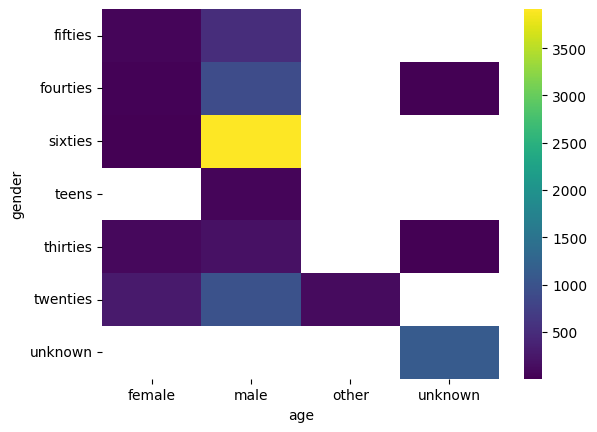

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Se crea DataFrame para el heatmap
df_2dhist = ds_acentos.groupby('age')['gender'].value_counts().unstack()

# Crea heatmap con seaborn
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('age')
plt.ylabel('gender')
plt.show()

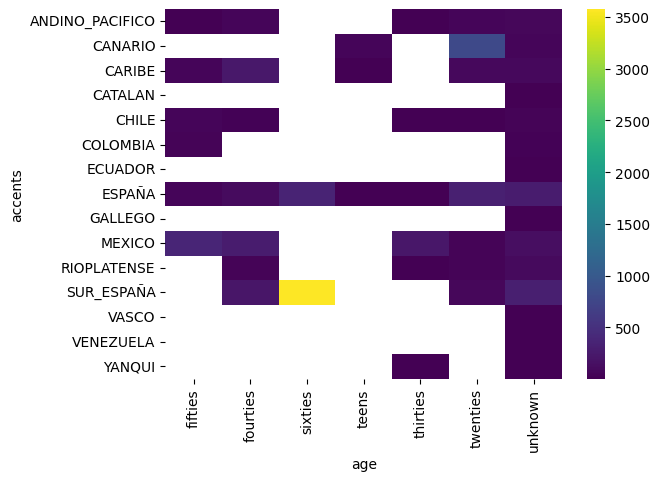

In [35]:
# Se crea DataFrame para el heatmap
df_2dhist = ds_acentos.groupby('accents')['age'].value_counts().unstack()

# Crea heatmap con seaborn
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('age')
plt.ylabel('accents')
plt.show()

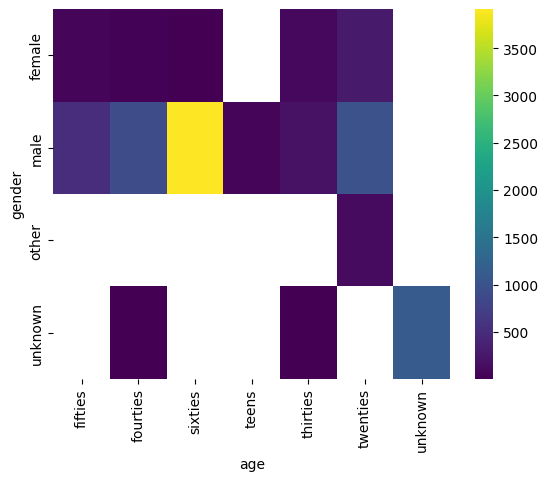

In [36]:
# Se crea DataFrame para el heatmap
df_2dhist = ds_acentos.groupby('gender')['age'].value_counts().unstack()

# Crea heatmap con seaborn
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('age')
plt.ylabel('gender')
plt.show()

In [37]:
ds_acentos.shape

(8257, 6)

### Exploración duración audios

In [38]:
ds_acentos.head(5)

,path,age,gender,accents,duration,labels
0,common_voice_es_38489062.mp3,unknown,unknown,SUR_ESPAÑA,7560,0
1,common_voice_es_38489063.mp3,unknown,unknown,SUR_ESPAÑA,7308,0
2,common_voice_es_38489064.mp3,unknown,unknown,SUR_ESPAÑA,7740,0
3,common_voice_es_38489065.mp3,unknown,unknown,SUR_ESPAÑA,6120,0
4,common_voice_es_38489066.mp3,unknown,unknown,SUR_ESPAÑA,8280,0


In [39]:
duration_min   = ds_acentos['duration'].min()
print(f'Audio más corto: {duration_min}(ms)')
duration_max   = ds_acentos['duration'].max()
print(f'Audio más largo: {duration_max}(ms)')
duration_mean   = ds_acentos['duration'].mean()
print(f'Duración media: {duration_mean:.2f}(ms)')
duration_median = ds_acentos['duration'].median()
print(f'Duración mediana: {duration_median:.2f}(ms)')

Audio más corto: 1584(ms)
Audio más largo: 11988(ms)
Duración media: 5060.66(ms)
Duración mediana: 4932.00(ms)


Text(0, 0.5, 'nº audios')

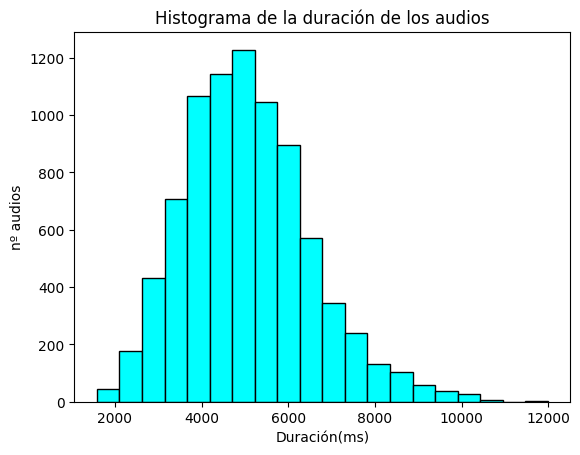

In [40]:
# Veamos el histograma de la duración de los audios
plt.hist(ds_acentos['duration'], bins=20, color='cyan', edgecolor='black')
plt.title('Histograma de la duración de los audios')
plt.xlabel('Duración(ms)')
plt.ylabel('nº audios')

---
## Definición de la clase pra el procesamiento de los audios

In [41]:
import os
import librosa
import librosa.display
import IPython
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchaudio
import numpy as np
import random

In [42]:
# Comprobamos si tenemos GPU disponible
if torch.cuda.is_available():
    # GPU disponible
    device = "cuda"
else:
    # GPU no disponible
    device = "cpu"
print(f"Using device {device}")

Using device cuda


In [43]:
# Configuración semilla
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Ruta a la carpeta que contiene los audios

In [44]:
audio_sample_path = path_datos + 'clips/'
index = 200
print(ds_other.iloc[index]['path'])
# obtener path de audio
audio_sample_path = os.path.join(audio_sample_path, ds_other.iloc[index]['path'])
audio_sample_path

common_voice_es_38495252.mp3


'/content/drive/MyDrive/Master_IA_UV/03 - Deep Learning 2/08 - Trabajo/dataset/cv-corpus-16.1-delta-2023-12-06/es/clips/common_voice_es_38495252.mp3'

In [45]:
# Escuchar audio
IPython.display.Audio(audio_sample_path)

### Definimos la clase que procesará los audios

In [46]:
class VoiceDataset(Dataset):

  def __init__(self,
               metadata_ds,
               audio_path,
               mel_espectogram,
               sample_rate,
               num_samples,
               device):
    # Ficheros con datos descriptivos del audio
    self.metadata = metadata_ds
    # Ruta donde se encuentan los audios
    self.audio_path = audio_path
    # Selección GPU o CPU
    self.device = device
    # Espectograma de MEL
    self.mel_espectogram = mel_espectogram.to(self.device)
    # Frecuencia de muestreo
    self.target_sample_rate = sample_rate
    # Número de muestras
    self.num_samples = num_samples

  def __len__(self):
    return len(self.metadata)

  def __getitem__(self, index):
    '''
    Método mágico.
    Itera sobre el path de audios realizando transformaciones
    '''
    # Obtención del path donde se encuentran los audios
    audio_path = self._get_audio_path(index)
    # Obtención de la etiqueta/target de los audios
    label = self._get_audio_label(index)
    # Cargar audio
    signal, sr = torchaudio.load(audio_path)
    # Cargamos la señal de entrada al dispositivo disponible
    signal = signal.to(self.device)
    # Remuestrea los audios para que todos sean iguales
    signal = self._resample_audio(signal, sr)
    # Convierte los audios a mono (mixing down)
    signal = self._audio2mono(signal)
    # Cortar audios largos
    signal = self._cut_audio(signal)
    # Alargar audios cortos (padding)
    signal = self._right_padding(signal)
    # Obtención espectograma MEL
    signal = self.mel_espectogram(signal)
    return signal, label#torch.tensor(label)

  def _get_audio_path(self, index):
    '''
    Obtención del path donde se encuentran cada audio
    '''
    path = os.path.join(self.audio_path, self.metadata.iloc[index]['path'])
    return path

  def _get_audio_label(self, index):
    '''
    Obtención de la etiqueta/target de cada audio
    '''
    return self.metadata.iloc[index]['labels']

  def _resample_audio(self, signal, sr):
    '''
    Remuestrea los audios para que todos sean iguales
    '''
    if self.target_sample_rate != sr:
      resample = torchaudio.transforms.Resample(sr, self.target_sample_rate)
      signal = resample(signal)
    return signal

  def _audio2mono(self, signal):
    '''
    Convierte los audios a mono (mixing down)
    '''
    # 1=señal mono
    if 1 < signal.shape[0]:
      signal = torch.mean(signal, dim=0, keepdim=True)
    return signal

  def _cut_audio(self, signal):
    '''
    Corta los audios largos.
    Se busca que todos tengan la misma longitud.
    '''
    audio_length = signal.shape[1]
    if self.num_samples < audio_length:
      signal = signal[:, :self.num_samples]
    return signal

  def _right_padding(self, signal):
    '''
    Alarga los audios cortos.
    Se busca que todos tengan la misma longitud.
    '''
    audio_length = signal.shape[1]
    if self.num_samples > audio_length:
      missing_samples = self.num_samples - audio_length
      padding_length  = (0, missing_samples)
      signal = nn.functional.pad(signal, padding_length)
    return signal

  def get_mel_spec_db(self, signal):
    '''
    Devuelbte el espectograma de MEL en dB
    @signal: señal de audio
    @return: tensor con la señal en dB
    '''
    mel_spec_db = torchaudio.transforms.AmplitudeToDB()(signal.to('cpu'))
    return mel_spec_db

  def get_mel_db_graph(self, signal_db=True, signal=None):
    '''
    Devuelve la gráfica del espectograma de MEL de una señal de audio.
    Si la señal ya está en dB, 'signal_db' debe valer True, en caso
    contrario se deberá pasar la señal para poder convertirla a dB
    '''
    if False == signal_db:
      signal = self.get_mel_spec_db(signal)

    signal = signal.to('cpu')

    signal_db = signal[0].detach().numpy()
    # Mostrar el espectrograma
    plt.figure(figsize=(10, 2))
    plt.imshow(signal_db, cmap='inferno', origin='lower')
    plt.xlabel('Tiempo')
    plt.ylabel('Frecuencia')
    plt.title('Espectrograma de MEL')
    plt.colorbar(format='%+2.0f dB')
    plt.show()


### Instanciamos la clase

In [47]:
# Ruta audios
audio_sample_path = path_datos + 'clips/'
print(f'audio_sample_path: {audio_sample_path}')
# Frecuencia de muestreo
SAMPLE_RATE = 32000
# Duración de un audio
AUDIO_TIME_LENGTH = 5 # segundos
# Número de muestras
# 5(s)*32k(sample_rate)
NUM_SAMPLES = AUDIO_TIME_LENGTH * SAMPLE_RATE
print(f'NUM_SAMPLES= {NUM_SAMPLES}')
# Tamaño de la FFT
n_fft = 1024
# Tamaño del desplazamiento de la FFT, normalemente FFT/2
hop_length= int(n_fft/2) # 512
# Número de coeficientes del filtro MEL
n_mels=64 # 6 bits, 2^6

# Definición del espectograma de MEL del audio
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels
)

audio_sample_path: /content/drive/MyDrive/Master_IA_UV/03 - Deep Learning 2/08 - Trabajo/dataset/cv-corpus-16.1-delta-2023-12-06/es/clips/
NUM_SAMPLES= 160000


In [48]:
vds = VoiceDataset(ds_acentos,
                   audio_sample_path,
                   mel_spectrogram,
                   SAMPLE_RATE,
                   NUM_SAMPLES,
                   device)

print(f"El dataset tiene {len(vds)} archivos de audio.")
signal, label = vds[8]
print(f'label: {label}')
print(f'signal: {signal}')

El dataset tiene 8257 archivos de audio.
label: 0
signal: tensor([[[1.0215e-10, 1.5326e-08, 4.1212e-06,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [4.0724e-11, 2.4966e-08, 4.4924e-06,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [4.5649e-11, 2.4457e-08, 4.7202e-06,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [1.0647e-18, 1.7075e-17, 8.5818e-15,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [9.2201e-19, 2.9273e-17, 7.1581e-15,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [9.0573e-19, 1.4012e-17, 7.4220e-15,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]]], device='cuda:0')


In [49]:
# shape= [nº channels, mel freq, time frame]
signal.shape

torch.Size([1, 64, 313])

Podemos ver que el espectrograma de MEL en tensor de Pytorch está compuesto por:

nº channels = 1

mel freq    = 64  <---esto lo hemos definido nosotros

audio_length = time(s) x sampling_rate = 5 x 32000=16000

time frame  = 313 <--- audio_legth / hop_length = 16000 / 512

#### Representamos un espectrograma de MEL en dB

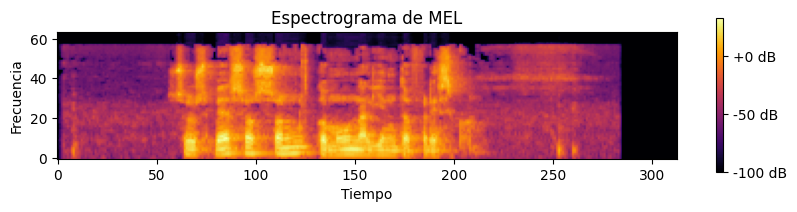

In [50]:
vds.get_mel_db_graph(signal_db=False, signal=signal)

---
## Definición de la arquitectura del modelo

In [51]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, device):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.num_directions = 1
        self.gru = nn.GRU(input_size,
                            self.hidden_size,
                            self.num_layers,
                            batch_first=True,
                            dropout=0.4,
                          bidirectional=False)
        self.fc1 = nn.Linear(hidden_size * self.num_directions,
                             num_classes)

    def forward(self, x):
       # Set hidden(h0) initial states
       x = x.float()
       batch_size = x.size(0)
       h0 = torch.zeros(self.num_layers * self.num_directions,
                        batch_size,
                        self.hidden_size).to(self.device)

       # out shape: (batch_size, seq_length, hidden_size)
       out, _ = self.gru(x, h0)
       # Decode the hidden state of the last time step
       out = self.fc1(out[:, -1, :])

       return out

In [52]:
# Create the model and put it on the GPU if available
Input_Size = n_mels # n_mels=64
#(time(s) x sampling_rate)/hop_length --> (5*32000)/512=313
Hidden_Size = 313
Num_Layers = 2
Num_Classes = len(tipos_acentos) # Clases= 15

print('------------------------')
print('Parámetros de entrada:')
print(f'Input_Size={Input_Size}')
print(f'Hidden_Size={Hidden_Size}')
print(f'Num_Layers={Num_Layers}')
print(f'Num_Classes={Num_Classes}')
print('------------------------')

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
model = RNN(Input_Size, Hidden_Size, Num_Layers, Num_Classes, device)
model = model.to(device)
# Check that it is on Cuda
next(model.parameters()).device
print('***  MODEL  ***')
print(model)

------------------------
Parámetros de entrada:
Input_Size=64
Hidden_Size=313
Num_Layers=2
Num_Classes=15
------------------------
Device: cuda
***  MODEL  ***
RNN(
  (gru): GRU(64, 313, num_layers=2, batch_first=True, dropout=0.4)
  (fc1): Linear(in_features=313, out_features=15, bias=True)
)


#### Separamos datos para la fase de train y test

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
# División de los datos en conjuntos de entrenamiento y prueba
metadata_train, metadata_test = train_test_split(ds_acentos,
                                                 test_size=0.2,
                                                 random_state=SEED)

# Instancia para crear el conjunto de entrenamiento
vds_train = VoiceDataset(metadata_train,
                         audio_sample_path,
                         mel_spectrogram,
                         SAMPLE_RATE,
                         NUM_SAMPLES,
                         device)

# Instancia para crear el conjunto de test
vds_test = VoiceDataset(metadata_test,
                        audio_sample_path,
                        mel_spectrogram,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

In [55]:
# Hyper-parameters
BATCH_SIZE = 16
EPOCHS = 15
LEARNING_RATE = 0.001

# Inicializacion de la funcion de perdida + optimizador
criterion = nn.CrossEntropyLoss() #Loss
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)
# Empleamos un optimizador de learning_rate
scheduler = ReduceLROnPlateau(optimizer,
                              mode='min',
                              factor=0.5,
                              patience=2,
                              verbose=False)


train_losses = []    # Lista para almacenar las pérdidas del entrenamiento
test_accuracies = [] # Lista para almacenar la precisión del modelo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [56]:
# Load checkpoints
MODEL_FILE_NAME = 'gru_h2_drp40_fc1'

# Función para guardar checkpoints
def save_checkpoint(epoch, model, optimizer, loss, chkpt_name=MODEL_FILE_NAME):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    #CHECKPOINT_PATH = '/content/drive/MyDrive/Master_IA_UV/03 - Deep Learning 2/08 - Trabajo/checkpoints/'
    CHECKPOINT_PATH = basic_path + 'checkpoints/' + chkpt_name + '.pt'
    torch.save(checkpoint, CHECKPOINT_PATH)
    print(f"Epoch_{epoch+1}: Checkpoint saved")

# Función para cargar un checkpoint
def load_checkpoint(model, optimizer, chkpt_name=MODEL_FILE_NAME):
  #CHECKPOINT_PATH = '/content/drive/MyDrive/Master_IA_UV/03 - Deep Learning 2/08 - Trabajo/checkpoints/'
  CHECKPOINT_PATH = basic_path + 'checkpoints/' + chkpt_name + '.pt'
  checkpoint = torch.load(CHECKPOINT_PATH)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  return model, optimizer, epoch, loss

In [57]:
def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    return train_dataloader

train_loader = create_data_loader(vds_train, BATCH_SIZE)
test_loader  = create_data_loader(vds_test,  BATCH_SIZE)

# Train
total_step = len(train_loader)
# Test
y_true = [] # To get confusion matrix
y_pred = [] # To get confusion matrix

### Fase de **Train**

In [58]:
def train_loop(epoch):
  model.train()
  epoch_train_loss = 0.0
  for i, (inputs, labels) in enumerate(train_loader):
    #inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
    # Reshape: [batch, nº channels, Mel freq, time frame] --> [batch, time frame, Mel freq]
    # Reshape: [16, 1, 64, 313] --> [16, 313, 64]
    inputs = torch.squeeze(torch.permute(inputs, (0,3,2,1)))
    # Load to device
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(inputs)
    # Loss
    loss = criterion(outputs, labels)

    # Set gradients to 0
    optimizer.zero_grad()
    # Backward and optimize
    loss.backward() # Gradient
    optimizer.step() # Update params

    epoch_train_loss += loss.item()

    if (i+1) % 50 == 0:
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
               .format(epoch+1, EPOCHS, i+1, total_step, loss.item()))

  # Save loss per epoch
  epoch_train_loss /= len(train_loader)
  train_losses.append(epoch_train_loss)
  print(f'Epoch_{epoch+1} loss= {epoch_train_loss:.4f}')

  # Update scheduler with train loss
  scheduler.step(epoch_train_loss)

  # Save checkpoints
  save_checkpoint(epoch, model, optimizer, loss, MODEL_FILE_NAME)


### Fase de **Test**

In [59]:
def test_loop(epoch):
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
      # Reshape: [batch, nº channels, Mel freq, time frame] --> [batch, time frame, Mel freq]
      # Reshape: [16, 1, 64, 313] --> [16, 313, 64]
      inputs = torch.squeeze(torch.permute(inputs, (0,3,2,1)))
      # Load to device
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      # stores data just in the last iteration
      if(EPOCHS == (epoch+1)):
        # Confusion matrix
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)
    print('Test Accuracy of the model: {:.2f} %'.format(test_accuracy))
  model.train()


In [60]:
for epoch in range(EPOCHS):
  train_loop(epoch)
  test_loop(epoch)

Epoch [1/15], Step [50/413], Loss: 1.9543
Epoch [1/15], Step [100/413], Loss: 1.4805
Epoch [1/15], Step [150/413], Loss: 1.0723
Epoch [1/15], Step [200/413], Loss: 0.7999
Epoch [1/15], Step [250/413], Loss: 1.2994
Epoch [1/15], Step [300/413], Loss: 1.1035
Epoch [1/15], Step [350/413], Loss: 1.1341
Epoch [1/15], Step [400/413], Loss: 0.6493
Epoch_1 loss= 1.1335
Epoch_1: Checkpoint saved
Test Accuracy of the model: 73.61 %
Epoch [2/15], Step [50/413], Loss: 0.9068
Epoch [2/15], Step [100/413], Loss: 0.6436
Epoch [2/15], Step [150/413], Loss: 0.3822
Epoch [2/15], Step [200/413], Loss: 0.5299
Epoch [2/15], Step [250/413], Loss: 0.6386
Epoch [2/15], Step [300/413], Loss: 0.8589
Epoch [2/15], Step [350/413], Loss: 0.7910
Epoch [2/15], Step [400/413], Loss: 0.3614
Epoch_2 loss= 0.6170
Epoch_2: Checkpoint saved
Test Accuracy of the model: 82.87 %
Epoch [3/15], Step [50/413], Loss: 1.0182
Epoch [3/15], Step [100/413], Loss: 0.7109
Epoch [3/15], Step [150/413], Loss: 0.3993
Epoch [3/15], Step [

In [61]:
import csv

# Saves relevant data
data_file_name = MODEL_FILE_NAME + '_data_graph.csv'
path_data_graphs = basic_path + 'checkpoints/' + data_file_name

# Combine lists
data = list(zip(train_losses, test_accuracies, y_true, y_pred))

# Save data in a CSV file
with open(path_data_graphs, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write Header
    writer.writerow(['Train_Losses', 'Test_Accuracies', 'y_true', 'y_pred'])
    # Write Data
    writer.writerows(data)
    print(f'Data saved')


Data saved


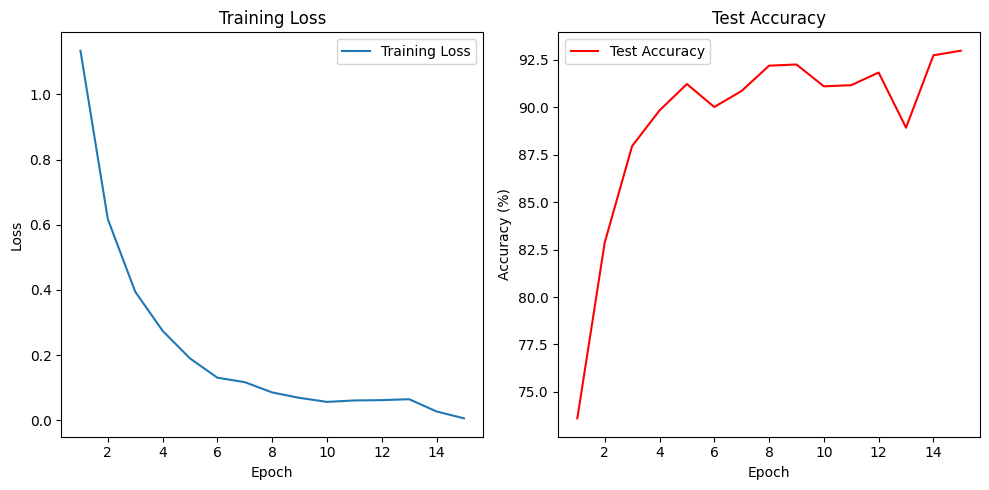

In [62]:
# Graficar la evolución de la pérdida de entrenamiento y la precisión de la prueba
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), test_accuracies, label='Test Accuracy', color='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

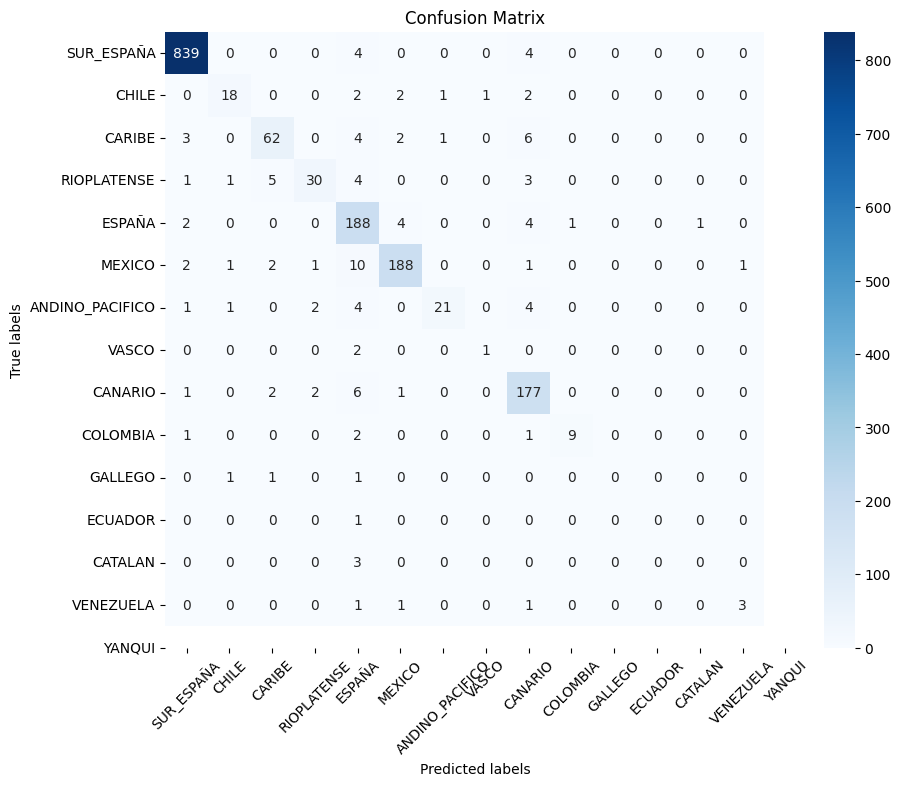

In [63]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
# Mapeo de índices a nombres de etiquetas
index_to_label = {v: k for k, v in accents_map.items()}

# Matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Establecer los nombres de las etiquetas
tick_labels = [index_to_label[i] for i in range(len(index_to_label))]
plt.xticks(np.arange(len(index_to_label))+0.5, tick_labels, rotation=45)
plt.yticks(np.arange(len(index_to_label))+0.5, tick_labels, rotation=0)

plt.show()